# Pytorch basics
Main target is to go through the tutorials from [here](https://www.youtube.com/playlist?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4). 

In [4]:
import torch
import numpy

### Tutorial 2: Tensor objects 

In [5]:
# ways to define torch objects
x = torch.empty(2, 2, dtype = torch.int)
y = torch.rand(2, 2, dtype = torch.float)
z = torch.zeros(2, 2)
z  = torch.ones(2, 2)
a = torch.tensor([[2,2], [3,3]], dtype = torch.float)

# I can do all these operations now
z = x + a
z = torch.add(x, a)
z = torch.sub(x, a)
z = torch.mul(x, a)
z = torch.div(x, a)

# slicing, reshaping data
x[0, :]
x.view(4) 
x.view(-1, 1)
x.reshape(1, 4)

# juggling between numpy and torch
z = z.numpy(); # print(type(z))
z = torch.from_numpy(z)

# A special case where we need a variable who's gradients need to be calculated
w = torch.ones(5, requires_grad = True)

Recap:
* numpy, torch -> libraries/ packages (inside that there'll be classes, functions, datatypes defined)
* x = torch.zeros(2) creates a torch object named x; I can see that using type(x)
* x.dtype will show the data type of the torch object x
* you'll notice sometimes we do x.type and sometimes x.size(). This is because type is an attribute of x and size is a function defined under that object

In [64]:
# sometimes if CUDA is available, it can accelerate a lot of computation. Looks like for my case, it is not but keeping the codes anyways
if torch.cuda.is_available():
    print('cuda available')
    device = torch.device("cuda")
    x = torch.ones(5, device = device)
    y = torch.ones(5);
    y = y.to(device);
    z = x + y # is faster because they are both in GPU
    # careful: z.numpy() cannot be done now cause numpy cannot work in GPU
    z = z.to("cpu")
    # Check number of CUDA devices available


### Tutorial 3: Gradient Calculation

In [67]:
x = torch.randn(3, requires_grad = True) # print(x) shows the flag 

In [83]:
y = x + 2; # Think of y as the output neuron and x and 2 are the input neurons. 
# If the RHS has requires_grad = True set, pytorch will automatically create an attribute grad_fn which is a function that can calculate dy/dx
print(y)
z = y * y * 2; 
z = z.mean(); 
print(z)
z.backward() # dz / dx # mean opeartion is necessary here because if z is a vector then it's a mess.

z = y * y * 2; # if z is not a scalar
v = torch.tensor([0.1, 1.0, .001], dtype = torch.float32); # 3d cause x is also 3d
z.backward(v)
print(x.grad)

tensor([2.9973, 1.6517, 1.1172], grad_fn=<AddBackward0>)
tensor(8.6401, grad_fn=<MeanBackward0>)
tensor([24.3784, 25.3258,  8.2014])


$Notice$ : z.backward() does not work for 
* vector z. I didn't understand how the vector v in the previous code was defined
* if I don't specify requires_grad = true

So, the part that fascillitates calculation of gradient to every new variable that are dependent on the original is the "requires_grad = True" command. 
This can be potentially dangerous as if we define a new varaible that depends on it, the new variable will start becoming a part of the gradients. 
To detach the variable from gradients there are three options: 

```python 
x.requires_grad_(False)
x.detach()
with torch.no_grad():
    {
        y = ...
    }
```

$Important$: *.grad keeps accumulating. So, we must empty the grad varaibles if we don't want it. The way to do that is by adding ```weights.grad.zero_()```

In [91]:
weights = torch.ones(4, requires_grad = True);
for epoch in range(3):
    model_output = (weights * 3).sum();
    model_output.backward()
    print(weights.grad)
    #weights.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([6., 6., 6., 6.])
tensor([9., 9., 9., 9.])


### Tutorial 4: Backpropagation

$\textbf{Chain rule:}$ x -> y = a(x) -> z = b(y); and we want to know 

dz/dx = dz/dy. dy/dx.

We use this to perform backpropagation in three steps: 
1. Forward pass
2. Compute the loss
3. backward pass & update

See the image at [this](https://www.youtube.com/watch?v=3Kb0QS6z7WA&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=4) link (5:35) for a better understanding of the variables w, x, y, yhat, s, L

In [98]:
x = torch.tensor(1.0)
y = torch.tensor(2.0)

w = torch.tensor(1.0, requires_grad = True)

yHat = w * x # forward pass

L = (yHat - y)**2

L.backward(); # backward pass

print(w.grad) 

tensor(-2.)


So, backpropagation is as simple as just typing L.backward()
and calculating gradient is also just parameter.grad.

### Tutorial 5: GD with autograd and Backpropagation

Try 1: Let's do it manually first to really appreciate what pytorch is doing for us. 

X = numpy.array([1, 2, 3, 4], dtype = "float32") doesn't work due to some formatting issue. See [this](https://stackoverflow.com/questions/43911844/numpy-float32-gives-different-value-from-dtype-float32-in-array) for details. 

In [121]:
# linear regression example (f = w* x). That is, we'll try to fit a set of data to this formula.
X = numpy.array([1, 2, 3, 4], dtype = numpy.float32);
Y = numpy.array([2, 4, 6, 8], dtype = numpy.float32); """ these are our input data. we'll create a model that fits this data. That is find the optimum w"""

w = 0 # wguess
# model
def forward(x):
    return w * x;

# loss
def loss(y, yHat):
    return ((yHat - y)**2).mean();

# gradient
def gradient(x, y, yHat):
    return numpy.dot(2 * x, yHat - y).mean(); 
print(f'Prediction before training : f(5) = {forward(5)}');

# Training
learningRate = 0.01
nIters = 100;

for epoch in range(nIters):
    YHat = forward(X);
    L = loss(Y, YHat);
    dw = gradient(X, Y, YHat);
    
    # update weights
    w -= learningRate * dw
    
    if epoch % 20 ==0:
        print(f'epoch {epoch + 1}: w = {w:.3f}, loss = {L:0.3f}');
print(f'Prediction after training: f(5) = {forward(5)}');

Prediction before training : f(5) = 0
epoch 1: w = 1.200, loss = 30.000
epoch 21: w = 2.000, loss = 0.000
epoch 41: w = 2.000, loss = 0.000
epoch 61: w = 2.000, loss = 0.000
epoch 81: w = 2.000, loss = 0.000
Prediction after training: f(5) = 9.99999977350235


Try 2: pytorch (calculate gradient automatically)

In [162]:
X = torch.tensor([1, 2, 3, 4], dtype = torch.float32);
Y = torch.tensor([2, 4, 6, 8], dtype = torch.float32); """ these are our input data. we'll create a model that fits this data. That is find the optimum w"""

w = torch.tensor(0.0, dtype = torch.float32, requires_grad = True) # wguess

# model (same as before)
def forward(x):
    return w * x;
 
# loss (same as before)
def loss(y, yHat):
    return ((yHat - y)**2).mean();

# gradient -> no need to write an explicit function!

# Training
learningRate = 0.01
nIters = 100;

print(f'Prediction before training : f(5) = {forward(5)}');
for epoch in range(nIters):
    YHat = forward(X);
    
    L = loss(Y, YHat);
    
    L.backward(); 
    
    # update weights
    with torch.no_grad(): # important: This is mandatory as we don't want to tie w with 
        w -= learningRate * w.grad;

    w.grad.zero_(); # have to make the gradients zero again. Why though? cause the L.backward() line will keep accumulating w.grad if we don't set it to zero every time
    
    if epoch % 20 ==0:
        print(f'epoch {epoch + 1}: w = {w:.3f}, loss = {L:0.3f}');
print(f'Prediction after training: f(5) = {forward(5)}');

Prediction before training : f(5) = 0.0
epoch 1: w = 0.300, loss = 30.000
epoch 21: w = 1.934, loss = 0.045
epoch 41: w = 1.997, loss = 0.000
epoch 61: w = 2.000, loss = 0.000
epoch 81: w = 2.000, loss = 0.000
Prediction after training: f(5) = 9.999998092651367


### Tutorial 6: Training pipeline: model, loss, and optimizer

It turns out, Pytorch lets us replace the manually computed loss, parameter updates. Steps: 

1. Design model (input, output, forward pass)
2. loss and optimizer
3. Tranining loop:
* forward pass: compute prediction
* backward pass: gradients
* update weights

In [178]:
import torch.nn 

learningRate = 0.01
nIters = 100;

X = torch.tensor([[1], [2], [3], [4]], dtype = torch.float32); # need the general case of nsamples and nfeatures so have to cast it into this form
Y = torch.tensor([[2], [4], [6], [8]], dtype = torch.float32); """ these are our input data. we'll create a model that fits this data. That is find the optimum w"""

X_test = torch.tensor([5], dtype = torch.float32);

nSamples, nFeatures = X.shape;
inputSize = nFeatures; outputSize = nFeatures;

model = torch.nn.Linear(inputSize, outputSize)

# loss and gradient can be automatically calculated (newly added)
LossFun = torch.nn.MSELoss();
optimizerFun = torch.optim.SGD(model.parameters(), lr=learningRate); 

print(f'Prediction before training : f(5) = {model(X_test).item()}');

for epoch in range(nIters):
    YHat = model(X);
    
    L = loss(Y, YHat);    
    
    L.backward(); 
    
    optimizerFun.step();
    
    optimizerFun.zero_grad(); # emptying the gradients
    
    if epoch % 20 ==0:
        [w, b] = model.parameters()
        print(f'epoch {epoch + 1}: w = {w[0][0].item():.3f}, loss = {L:0.3f}');
        
print(f'Prediction after training: f(5) = {forward(5)}');

Prediction before training : f(5) = -1.354038953781128
epoch 1: w = -0.104, loss = 35.267
epoch 21: w = 1.495, loss = 0.335
epoch 41: w = 1.563, loss = 0.276
epoch 61: w = 1.589, loss = 0.245
epoch 81: w = 1.613, loss = 0.217
Prediction after training: f(5) = tensor([[8.1729]], grad_fn=<MulBackward0>)


In [176]:
# we can define the model more formally too like this
class LinearRegression(torch.nn.Module):
    def __init__(self, inputDim, outputDim):
        super(LinearRegression, self).__init__()
        self.lin = torch.nn.Linear(inputDim, outputDim)
        
    def forward(self, x):
        return self.lin(x)
    
model = LinearRegression(inputSize, outputSize)

### Tutorial 7: Recap of Linear regression

In [1]:
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


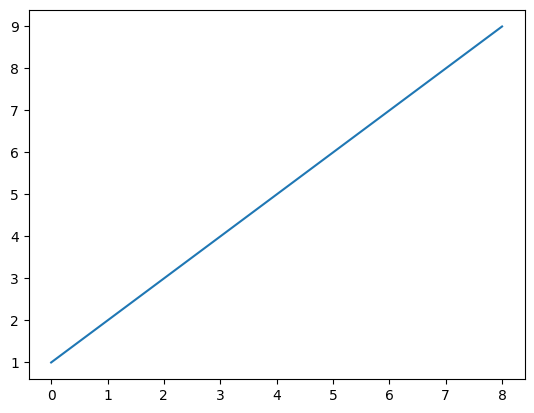

In [2]:
plot(range(1,10))